In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
from scipy.sparse.linalg import eigs


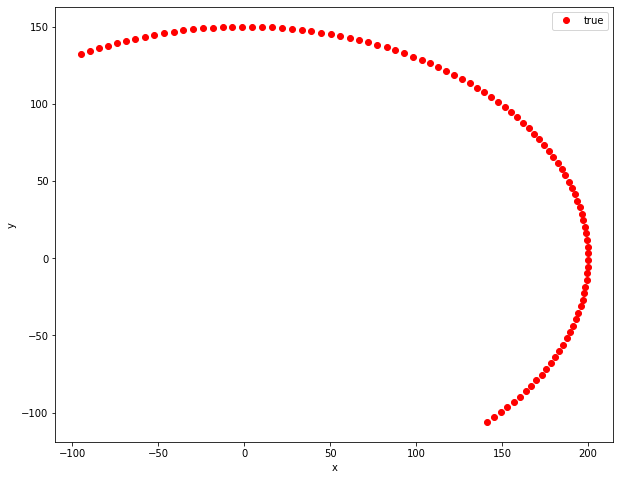

In [34]:
# 課題2

N = 100 #楕円座標データの点の数
iteration = 1000 #データ生成の繰り返しの数


class Ex2:
    def __init__(self):
        self.theta = (-1 * np.pi) / 4 + ((11 * np.pi) /
                                         (12 * N) * np.arange(0, N))
        self.x = 200*np.cos(self.theta)
        self.y = 150*np.sin(self.theta)

    #プロットと画像データの保存
    def showfig(self):
        plt.figure(figsize=(10, 8))
        plt.plot(self.x, self.y, color="red",
                 linestyle="None", marker='o', label="true")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(loc="best")
        plt.savefig("fig/fig2.pdf")

ex2 = Ex2()
ex2.showfig()


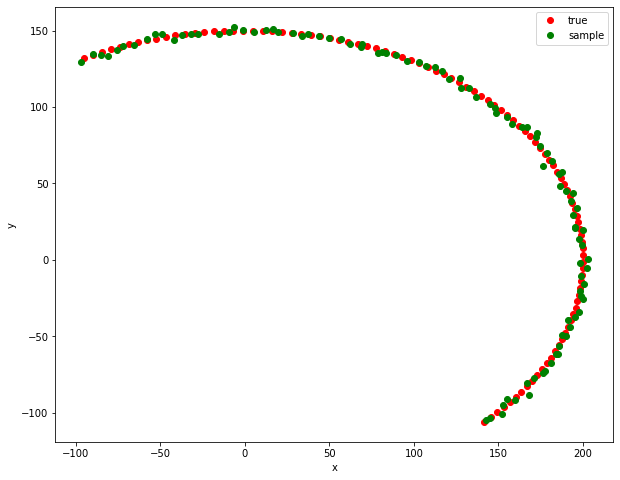

In [63]:
# 課題3
class Ex3:
    def __init__(self, ex2):
        self.ex2 = ex2
        #Ex2のクラス内の座標をコピーする
        self.x = np.copy(self.ex2.x)
        self.y = np.copy(self.ex2.y)
        #誤差を加える
        self.x += np.random.normal(loc=0, scale=2, size=N)
        self.y += np.random.normal(loc=0, scale=2, size=N)

    def showfig(self):
        plt.figure(figsize=(10, 8))
        plt.plot(self.ex2.x, self.ex2.y, color="red",
                 linestyle="None", marker='o', label="true")
        plt.plot(self.x, self.y, color="green",
                 linestyle="None", marker='o', label="sample")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(loc="best")
        plt.savefig("fig/fig3.pdf")

ex3 = Ex3(ex2)
ex3.showfig()


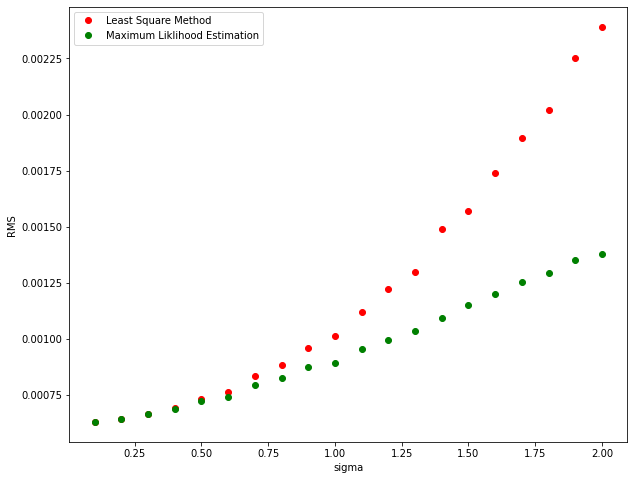

In [60]:
# 課題4-5
class Ex4_5:
    def __init__(self, ex3):
        self.ex3 = ex3
        self.sigma = np.arange(start=0.1, stop=2.1, step=0.1) #標準偏差の値
        self.u_bar = np.array([2.5*(10**(-5)), 4.4*(10**(-5)), 0, 0, 0, -1]) #真のパラメータ
        self.rms = np.zeros((2, 20))  # RMS 最小二乗法と最尤推定法をまとめて格納
        self.kcr=np.zeros((1,20))

    # 最小二乗法と最尤推定法のRMSを測定
    def calculate_ex4(self):
        for i, s in enumerate(self.sigma):
            for j in range(iteration):
                x, y = np.copy(self.ex3.ex2.x), np.copy(self.ex3.ex2.y)
                #誤差の付与
                x += np.random.normal(loc=0, scale=s, size=N)
                y += np.random.normal(loc=0, scale=s, size=N)
                #最小二乗法と最尤推定法のパラメータの推定
                u_lsm = self.LSM(x, y)
                u_mle = self.MLE(x, y, i)
                #RMS誤差の計算
                self.rms[0][i] += self.RMS(u_lsm, self.u_bar)/N
                self.rms[1][i] += self.RMS(u_mle, self.u_bar)/N
    
    #KCR下界を測定            
    def calculate_ex5(self)->np.ndarray:
        m_kcr=self.M_KCR(self.ex3.ex2.x,self.ex3.ex2.y,self.sigma)
        v_kcr=np.linalg.eigvals(m_kcr)
        kcr=np.sqrt(1/np.sum(v_kcr[0:5]))
        return self.sigma*kcr

    #最小二乗法
    def LSM(self, x, y)->np.ndarray:
        m = self.matrix_m_lsm(x, y)
        value, vector = np.linalg.eig(m)
        index = np.abs(value).argsort()[0]
        param = np.atleast_2d(vector[:, index]).T
        return param

    #最尤推定法
    def MLE(self, x, y, sigma)->np.ndarray:
        new = np.zeros((6, 1))
        old = np.zeros((6, 1))
        k = 0
        while True:
            k += 1
            M = self.matrix_m_mle(x, y, old, sigma)
            L = self.matrix_l_mle(x, y, old, sigma)
            value, vector = np.linalg.eig(M - L)
            index = np.abs(value).argsort()[0]
            new = np.atleast_2d(vector[:, index]).T
            if np.linalg.norm(old-new, ord=2) < 0.00001: #閾値の設定
                break
            old = new
        return new

    #最小二乗法で使われる行列Mの計算
    def matrix_m_lsm(self, x, y)->np.ndarray:
        m = np.zeros([6, 6])
        for xi, yi in zip(x, y):
            ksi = self.ksi(xi, yi)
            m += ksi.dot(ksi.T)
        return m

    #最尤推定法で使われる行列Mの計算
    def matrix_m_mle(self, x, y, u, sigma)->np.ndarray:
        m = np.zeros((6,6))
        for xi, yi in zip(x, y):
            ksi = self.ksi(xi, yi)
            v = self.covariance(xi, yi, sigma)
            if u.T.dot(v.dot(u)) == 0:
                m += ksi.dot(ksi.T)
            else:
                m += ksi.dot(ksi.T)/u.T.dot(v.dot(u))
        return m

    #最尤推定法で使われる行列Lの計算
    def matrix_l_mle(self, x, y, u, sigma)->np.ndarray:
        l = np.zeros([6, 6])
        for xi, yi in zip(x, y):
            ksi = self.ksi(xi, yi)
            v = self.covariance(xi, yi, sigma)
            if u.T.dot(v.dot(u)) == 0:
                l += (ksi.T.dot(u))**2 * v
            else:
                l += (ksi.T.dot(u))**2 * v / u.T.dot(v.dot(u))**2
        return l

    #xとyから成るベクトルの計算
    def ksi(self, xi, yi)->np.ndarray:
        return np.array([[xi*xi, 2*xi*yi, yi*yi, 2*xi, 2*yi, 1]]).T

    #共分散行列の計算
    def covariance(self, xi, yi, sig)->np.ndarray:
        matrix = np.array([
            [xi*xi,   xi*yi,            0,      xi, 0, 0],
            [xi*yi,   (xi*xi)+(yi*yi),    xi*yi,    yi, xi, 0],
            [0,     xi*yi,            yi*yi,    0, yi, 0],
            [xi,     yi,              0,      1, 0, 0],
            [0,     xi,              yi,      0, 1, 0],
            [0,     0,              0,      0, 0, 0]
        ])
        if sig!=0:
            #4*sigma^2をかける(計算の都合でsig=0にすることでここをスルーできるようにする)
            matrix = 4*sig*sig*matrix 
        return matrix

    #RMS誤差の計算
    def RMS(self, u, u_bar)->np.ndarray:
        P_u = np.identity(6)-np.outer(u_bar, u_bar)
        delta_u = P_u.dot(u)
        rms = np.linalg.norm(delta_u, ord=2)
        return rms
    
    #KCR下界の計算
    def M_KCR(self,x,y,sig)->np.ndarray:
        m=np.zeros([6,6])
        u=self.u_bar
        for xi,yi in zip(x,y):
            v=self.covariance(xi,yi,sig=0)
            ksi=self.ksi(xi,yi)
            m+=ksi.dot(ksi.T)/u.dot(v.dot(u.T))
        return m

    #(4)のグラフを描画
    def showfig_ex4(self):
        plt.figure(figsize=(10, 8))
        plt.plot(self.sigma, self.rms[0,:], color="red",
                 linestyle="None", marker='o', label="Least Square Method")
        plt.plot(self.sigma, self.rms[1,:], color="green",
                 linestyle="None", marker='o', label="Maximum Liklihood Estimation")
        plt.xlabel("sigma")
        plt.ylabel("RMS")
        plt.legend(loc="best")
        plt.savefig("fig/fig4.pdf")
    
    #(5)のグラフを描画    
    def showfig_ex5(self):
        plt.figure(figsize=(10, 8))
        plt.plot(self.sigma, self.rms[0,:], color="red",
                 linestyle="None", marker='o', label="Least Square Method")
        plt.plot(self.sigma, self.rms[1,:], color="green",
                 linestyle="None", marker='o', label="Maximum Liklihood Estimation")
        a=np.multiply(self.sigma,self.sigma)*4
        plt.plot(self.sigma, np.multiply(a,self.kcr[0,:]), color="blue",
                 linestyle="None", marker='o', label="KCR")
        plt.xlabel("sigma")
        plt.ylabel("RMS")
        plt.legend(loc="best")
        plt.savefig("fig/fig5.pdf") 
        
ex4_5=Ex4_5(ex3)
ex4_5.calculate_ex4()
ex4_5.showfig_ex4()

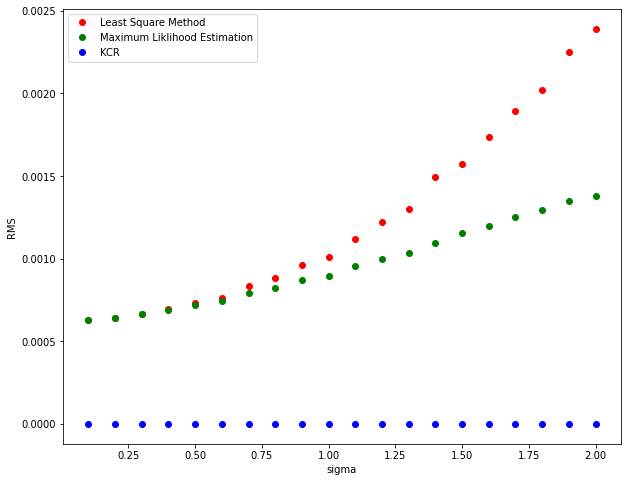

In [61]:
ex4_5.calculate_ex5()
ex4_5.showfig_ex5()